In [128]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline

from catboost import CatBoostClassifier
from xgboost import XGBClassifier

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as imbPipeline

## 1. EDA

1.1 Data exploration

In [129]:
df = pd.read_csv("bank_full.csv")

In [130]:
df.shape

(45211, 17)

In [131]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


In [132]:
#checking the features
df.head(10)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no
5,35,management,married,tertiary,no,231,yes,no,unknown,5,may,139,1,-1,0,unknown,no
6,28,management,single,tertiary,no,447,yes,yes,unknown,5,may,217,1,-1,0,unknown,no
7,42,entrepreneur,divorced,tertiary,yes,2,yes,no,unknown,5,may,380,1,-1,0,unknown,no
8,58,retired,married,primary,no,121,yes,no,unknown,5,may,50,1,-1,0,unknown,no
9,43,technician,single,secondary,no,593,yes,no,unknown,5,may,55,1,-1,0,unknown,no


In [133]:
#checking for null values
print(df.isna().sum())

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64


In [ ]:
num_cols = df.select_dtypes(include=['int64','float64']).columns #selecting numerical columns
df[num_cols].describe()

,age,balance,day,duration,campaign,pdays,previous
count,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.936210,1362.272058,15.806419,258.163080,2.763841,40.197828,0.580323
std,10.618762,3044.765829,8.322476,257.527812,3.098021,100.128746,2.303441
min,18.000000,-8019.000000,1.000000,0.000000,1.000000,-1.000000,0.000000
25%,33.000000,72.000000,8.000000,103.000000,1.000000,-1.000000,0.000000
50%,39.000000,448.000000,16.000000,180.000000,2.000000,-1.000000,0.000000
75%,48.000000,1428.000000,21.000000,319.000000,3.000000,-1.000000,0.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000,871.000000,275.000000


In [ ]:
num_duplicates = df.duplicated().sum() #counting the number of duplicate rows
print(num_duplicates)

0


#### 1.2 Data visualization

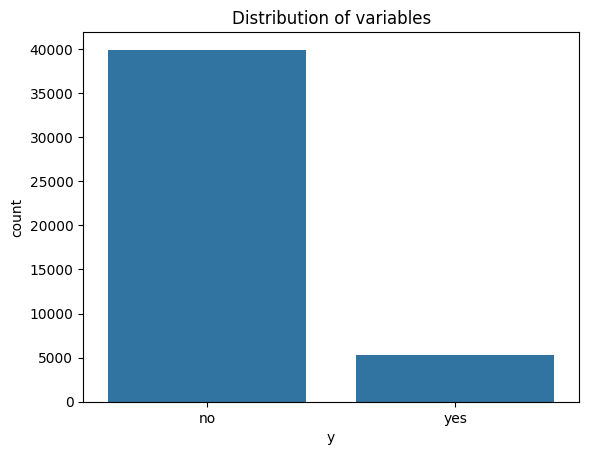

In [135]:
#checking the categorical features
sns.countplot(x='y', data=df)
plt.title('Distribution of variables')
plt.show()

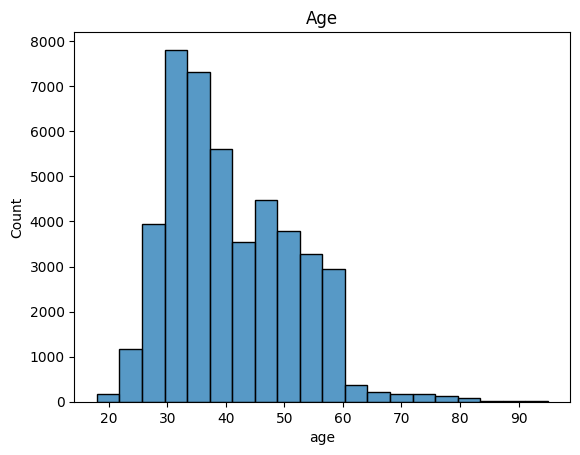

In [136]:
# Visualizing the distribution of 'age' column
sns.histplot(df['age'],bins=20)
plt.title('Age')
plt.show()

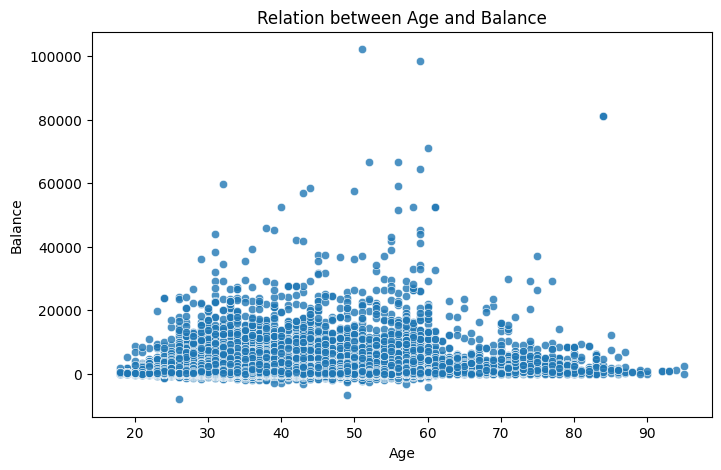

In [ ]:
plt.figure(figsize=(8, 5))
sns.scatterplot(x='age', y='balance', data=df, alpha=0.8)
plt.title('Relation between Age and Balance')
plt.xlabel('Age')
plt.ylabel('Balance')
plt.show()
#checking the distribution of the target variable with respect to the balance

#### 1.3 Correlation Analysis

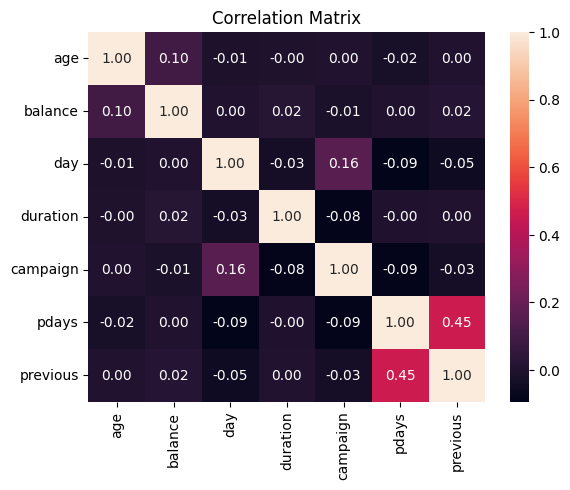

In [138]:
#looking at the relation between numerical features
correlation = df[num_cols].corr()
sns.heatmap(correlation, annot=True,fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

#### 1.4 Data engineering

In [139]:
cat_cols = df.select_dtypes(include=['object']).columns
cat_cols = cat_cols.drop('y')  # Exclude target variable

In [ ]:
def create_prep():
    num_transformer = Pipeline(steps=[('scaler', StandardScaler())]) #for ranging variables

    cat_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))]) #for categorical variables one-hot encoding  

    prep = ColumnTransformer(transformers=[('num', num_transformer, num_cols),
                                           ('cat', cat_transformer, cat_cols)]) #for combining numerical and categorical transformations
    return prep

preprocessor = create_prep() 

## 2. Model Building (Построение моделей)

#### 3.1 Logistic Regression

In [141]:
X = df.drop(columns = 'y', axis=1)  # Features
Y= df['y'].map({'yes': 1, 'no': 0}) # Convert target variable to binary

In [142]:
Y

0        0
1        0
2        0
3        0
4        0
        ..
45206    1
45207    1
45208    1
45209    0
45210    0
Name: y, Length: 45211, dtype: int64

In [ ]:
Xtrain, Xtest, Ytrain, Ytest = train_test_split( X, Y, test_size=0.2, random_state=42, stratify=Y) #creating train and test sets

In [ ]:
pipe = imbPipeline(steps=[('prep', preprocessor),
                            ('smote', SMOTE(random_state=42)),
                            ('logreg', LogisticRegression(random_state=42,max_iter=1000))]) #creating a pipeline with preprocessing, oversampling and model

In [ ]:
pipe.fit(Xtrain,Ytrain)
Ypred = pipe.predict(Xtest)
Yprob = pipe.predict_proba(Xtest)[:, 1] #predicting the probabilities of the positive class

In [146]:
Yprob

array([0.02089344, 0.0354636 , 0.0651534 , ..., 0.24413619, 0.19228718,
       0.08553175], shape=(9043,))

In [ ]:
print("classification_report")
print(classification_report(Ytest, Ypred)) #classification report that indlusdes precision, recall, f1-score and support for each class


classification_report
              precision    recall  f1-score   support

           0       0.97      0.85      0.91      7985
           1       0.42      0.80      0.55      1058

    accuracy                           0.85      9043
   macro avg       0.69      0.83      0.73      9043
weighted avg       0.91      0.85      0.87      9043



accuracy_score =  0.8467322791109145
precision_score =  0.41921182266009854
recall_score =  0.8043478260869565
f1_score =  0.5511658031088082
ROC AUC =  0.9065593214119575


Text(0.5, 1.0, 'Confusion Matrix')

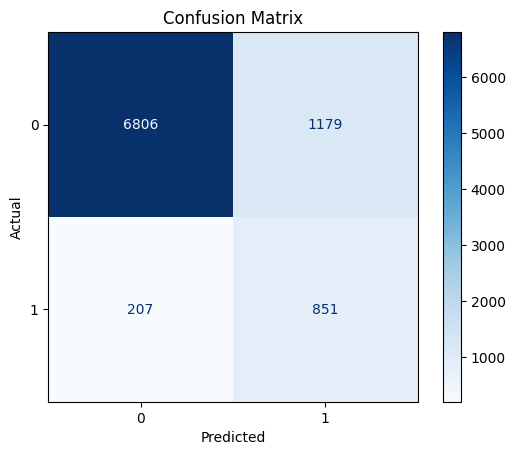

In [ ]:
from sklearn.metrics import roc_auc_score
print("accuracy_score = ", accuracy_score(Ytest, Ypred))
print("precision_score = ", precision_score(Ytest, Ypred))
print("recall_score = ", recall_score(Ytest, Ypred))    
print("f1_score = ", f1_score(Ytest, Ypred))
ConfusionMatrixDisplay.from_estimator(pipe, Xtest, Ytest, cmap='Blues')
cm = confusion_matrix(Ytest, Ypred)
print("ROC AUC = ", roc_auc_score(Ytest, Yprob))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
#looking at the all scores in order to compare the models



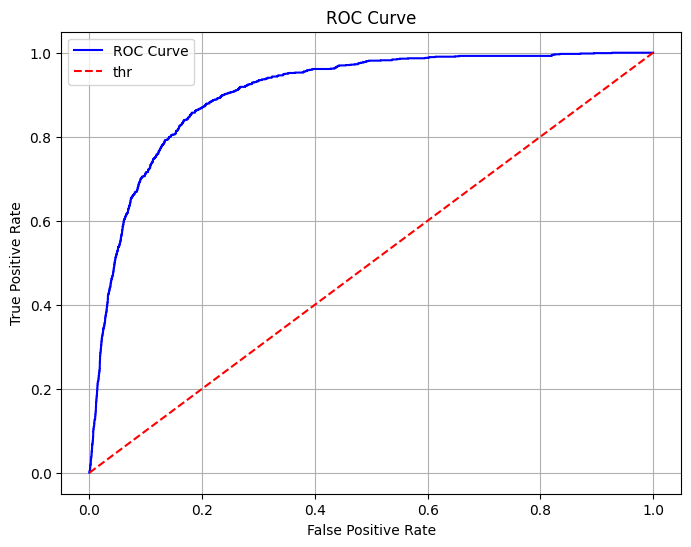

In [ ]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(Ytest, Yprob)  
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC Curve', color='blue')
plt.title('ROC Curve')
plt.plot([0, 1], [0, 1], linestyle='--', color='red', label='thr')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')    
plt.legend()
plt.grid()  
plt.show()
# looking at the ROC curve to evaluate the model performance


In [ ]:
Xsmote, Ysmote = pipe.named_steps['smote'].fit_resample(preprocessor.fit_transform(Xtrain), Ytrain)
print(Ysmote.value_counts()) #looking at the distribution of the target variable after oversampling

y
0    31937
1    31937
Name: count, dtype: int64


#### 3.2 Decision Tree

In [ ]:
pipe = imbPipeline(steps=[('prep', preprocessor),
                            ('smote', SMOTE(random_state=42)),
                            ('dectree', DecisionTreeClassifier(random_state=42))])
pipe.fit(Xtrain,Ytrain)
Ypred = pipe.predict(Xtest)
Yprob = pipe.predict_proba(Xtest)[:, 1]     #doing the same with Decision Tree Classifier

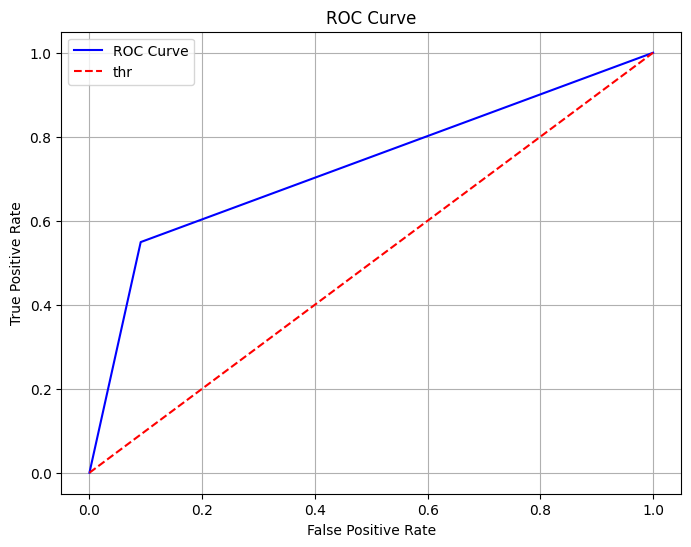

In [152]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(Ytest, Yprob)  
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC Curve', color='blue')
plt.title('ROC Curve')
plt.plot([0, 1], [0, 1], linestyle='--', color='red', label='thr')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')    
plt.legend()
plt.grid()  
plt.show()

In [153]:
print("classification_report")
print(classification_report(Ytest, Ypred))
print("ROC AUC = ", roc_auc_score(Ytest, Yprob))

classification_report
              precision    recall  f1-score   support

           0       0.94      0.91      0.92      7985
           1       0.44      0.55      0.49      1058

    accuracy                           0.87      9043
   macro avg       0.69      0.73      0.71      9043
weighted avg       0.88      0.87      0.87      9043

ROC AUC =  0.7291144312409965


#### 3.3 Random Forest

In [154]:
pipe = imbPipeline(steps=[('prep', preprocessor),
                            ('smote', SMOTE(random_state=42)),
                            ('randfor', RandomForestClassifier(random_state=42))])
pipe.fit(Xtrain,Ytrain)
Ypred = pipe.predict(Xtest)
Yprob = pipe.predict_proba(Xtest)[:, 1]

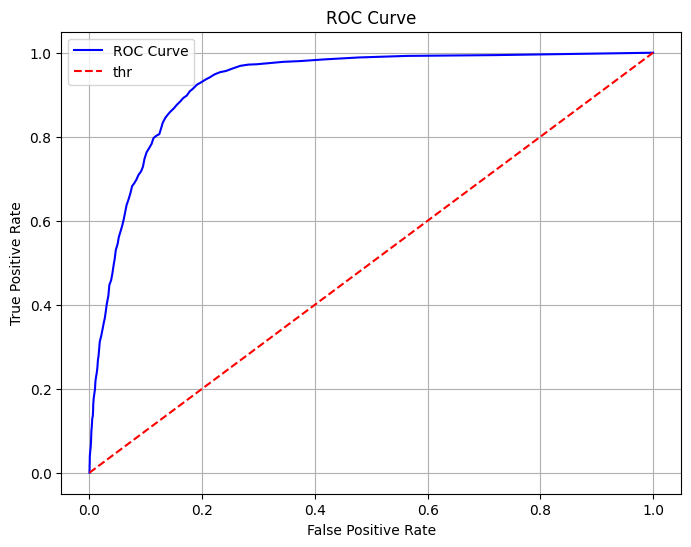

In [155]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(Ytest, Yprob)  
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC Curve', color='blue')
plt.title('ROC Curve')
plt.plot([0, 1], [0, 1], linestyle='--', color='red', label='thr')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')    
plt.legend()
plt.grid()  
plt.show()

In [156]:
print("classification_report")
print(classification_report(Ytest, Ypred))
print("ROC AUC = ", roc_auc_score(Ytest, Yprob))

classification_report
              precision    recall  f1-score   support

           0       0.94      0.95      0.95      7985
           1       0.59      0.56      0.57      1058

    accuracy                           0.90      9043
   macro avg       0.77      0.75      0.76      9043
weighted avg       0.90      0.90      0.90      9043

ROC AUC =  0.9259350294088751


#### 3.4 XGBoost

In [167]:
pipe = imbPipeline(steps=[('prep', preprocessor),
                            ('smote', SMOTE(random_state=42)),
                            ('xg', XGBClassifier(random_state=42, use_label_encoder = False, eval_metric='logloss'))])
pipe.fit(Xtrain,Ytrain)
Ypred = pipe.predict(Xtest)
Yprob = pipe.predict_proba(Xtest)[:, 1]

c:\Users\User\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [20:26:48] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


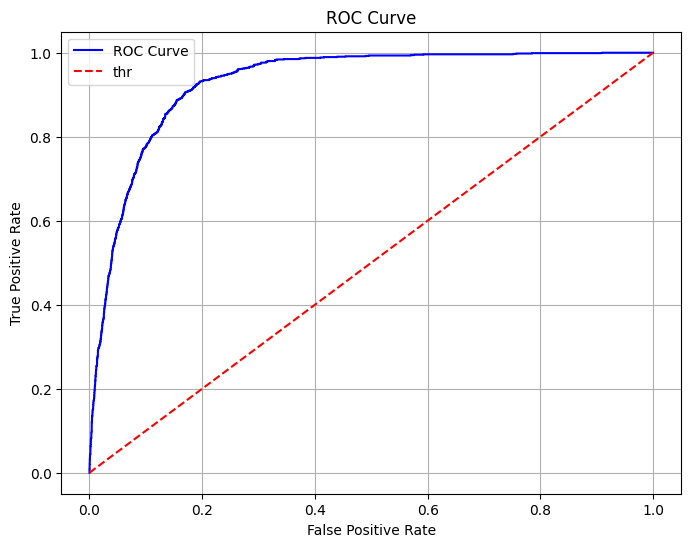

In [170]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(Ytest, Yprob)  
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC Curve', color='blue')
plt.title('ROC Curve')
plt.plot([0, 1], [0, 1], linestyle='--', color='red', label='thr')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')    
plt.legend()
plt.grid()  
plt.show()

In [169]:
print("classification_report")
print(classification_report(Ytest, Ypred))
print("ROC AUC = ", roc_auc_score(Ytest, Yprob))

classification_report
              precision    recall  f1-score   support

           0       0.94      0.95      0.95      7985
           1       0.61      0.57      0.59      1058

    accuracy                           0.91      9043
   macro avg       0.78      0.76      0.77      9043
weighted avg       0.90      0.91      0.91      9043

ROC AUC =  0.9301413448893423


#### 3.5 CatBoost

In [ ]:
pipe = imbPipeline(steps=[('prep', preprocessor),
                            ('smote', SMOTE(random_state=42)),
                            ('catb', CatBoostClassifier(verbose=0, random_state=42))]) #defining a pipeline with CatBoost Classifier
pipe.fit(Xtrain,Ytrain)
Ypred = pipe.predict(Xtest)
Yprob = pipe.predict_proba(Xtest)[:, 1]

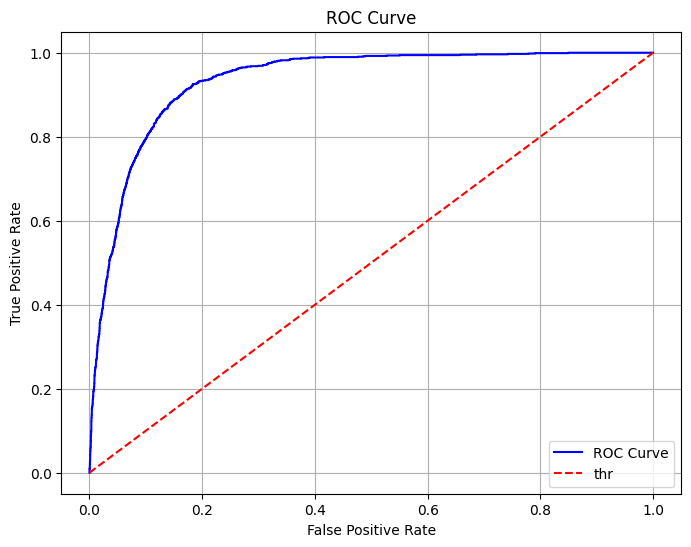

In [172]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(Ytest, Yprob)  
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC Curve', color='blue')
plt.title('ROC Curve')
plt.plot([0, 1], [0, 1], linestyle='--', color='red', label='thr')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')    
plt.legend()
plt.grid()  
plt.show()

In [173]:
print("classification_report")
print(classification_report(Ytest, Ypred))
print("ROC AUC = ", roc_auc_score(Ytest, Yprob))

classification_report
              precision    recall  f1-score   support

           0       0.94      0.95      0.95      7985
           1       0.62      0.56      0.59      1058

    accuracy                           0.91      9043
   macro avg       0.78      0.76      0.77      9043
weighted avg       0.90      0.91      0.91      9043

ROC AUC =  0.9338580253854996


Для 2 лучших алгоритмов:

In [177]:
from sklearn.model_selection import cross_val_score, GridSearchCV
# 1. Задаём конвейеры
pipe_xgb = imbPipeline([
    ('prep', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('xg', XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'))
])

pipe_cat = imbPipeline([
    ('prep', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('catb', CatBoostClassifier(verbose=0, random_state=42))
])




In [178]:
# 2. Базовая оценка k-fold CV (k=5) по ROC-AUC
print("Baseline CV ROC-AUC:")
scores_xgb = cross_val_score(pipe_xgb, Xtrain, Ytrain, cv=5, scoring='roc_auc', n_jobs=-1)
scores_cat = cross_val_score(pipe_cat, Xtrain, Ytrain, cv=5, scoring='roc_auc', n_jobs=-1)
print(f" XGBoost : {scores_xgb.round(3)} → mean = {scores_xgb.mean():.3f}")
print(f" CatBoost: {scores_cat.round(3)} → mean = {scores_cat.mean():.3f}\n")

Baseline CV ROC-AUC:
 XGBoost : [0.93  0.929 0.928 0.929 0.935] → mean = 0.930
 CatBoost: [0.938 0.936 0.934 0.935 0.939] → mean = 0.936



In [ ]:
# 3. Grid Search для XGBoost
param_grid_xgb = {
    'xg__n_estimators':    [100, 200],
    'xg__max_depth':       [3, 5],
    'xg__learning_rate':   [0.01, 0.1],
    'xg__subsample':       [0.8, 1.0]
}
grid_xgb = GridSearchCV(
    estimator=pipe_xgb, #for parameter tuning
    param_grid=param_grid_xgb,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)
grid_xgb.fit(Xtrain, Ytrain)
print("XGBoost best params:", grid_xgb.best_params_)
print("XGBoost best CV ROC-AUC:", grid_xgb.best_score_.round(3), "\n")

Fitting 5 folds for each of 16 candidates, totalling 80 fits


c:\Users\User\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:26:32] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost best params: {'xg__learning_rate': 0.1, 'xg__max_depth': 5, 'xg__n_estimators': 200, 'xg__subsample': 0.8}
XGBoost best CV ROC-AUC: 0.932 



In [180]:
# 4. Grid Search для CatBoost
param_grid_cat = {
    'catb__iterations':    [100, 200],
    'catb__depth':         [4, 6],
    'catb__learning_rate': [0.01, 0.1],
    'catb__l2_leaf_reg':   [1, 3]
}
grid_cat = GridSearchCV(
    estimator=pipe_cat,
    param_grid=param_grid_cat,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)
grid_cat.fit(Xtrain, Ytrain)
print("CatBoost best params:", grid_cat.best_params_)
print("CatBoost best CV ROC-AUC:", grid_cat.best_score_.round(3), "\n")


Fitting 5 folds for each of 16 candidates, totalling 80 fits
CatBoost best params: {'catb__depth': 6, 'catb__iterations': 200, 'catb__l2_leaf_reg': 3, 'catb__learning_rate': 0.1}
CatBoost best CV ROC-AUC: 0.935 



In [181]:
# 5. Оценка на тесте с лучшими моделями
best_xgb = grid_xgb.best_estimator_
best_cat = grid_cat.best_estimator_

test_score_xgb = best_xgb.score(Xtest, Ytest)
test_score_cat = best_cat.score(Xtest, Ytest)
print("Test ROC-AUC with tuned models:")
print(f" XGBoost : {test_score_xgb:.3f}")
print(f" CatBoost: {test_score_cat:.3f}")

Test ROC-AUC with tuned models:
 XGBoost : 0.905
 CatBoost: 0.909


In [188]:
# 1. Соберём «дефолтные» конвейеры без тюнинга
default_xgb = imbPipeline([
    ('prep', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('xg', XGBClassifier(
        random_state=42, 
        use_label_encoder=False, 
        eval_metric='logloss'
    ))
])
default_cat = imbPipeline([
    ('prep', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('catb', CatBoostClassifier(
        verbose=0, 
        random_state=42
    ))
])

# 2. Обучаем дефолтные модели
default_xgb.fit(Xtrain, Ytrain)
default_cat.fit(Xtrain, Ytrain)

# 3. ROC-AUC «до» тюнинга на тесте
yprob_def_xgb = default_xgb.predict_proba(Xtest)[:, 1]
yprob_def_cat = default_cat.predict_proba(Xtest)[:, 1]
base_auc_xgb = roc_auc_score(Ytest, yprob_def_xgb)
base_auc_cat = roc_auc_score(Ytest, yprob_def_cat)

# 4. Берём «тюненные» лучшие модели
best_xgb = grid_xgb.best_estimator_
best_cat = grid_cat.best_estimator_

# 5. ROC-AUC «после» тюнинга на тесте
yprob_tuned_xgb = best_xgb.predict_proba(Xtest)[:, 1]
yprob_tuned_cat = best_cat.predict_proba(Xtest)[:, 1]
tuned_auc_xgb = roc_auc_score(Ytest, yprob_tuned_xgb)
tuned_auc_cat = roc_auc_score(Ytest, yprob_tuned_cat)

# 6. Выводим сравнение
print(f"XGBoost ROC-AUC: baseline = {base_auc_xgb:.3f}, tuned = {tuned_auc_xgb:.3f}")
print(f"CatBoost ROC-AUC: baseline = {base_auc_cat:.3f}, tuned = {tuned_auc_cat:.3f}")

c:\Users\User\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [23:13:14] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost ROC-AUC: baseline = 0.930, tuned = 0.931
CatBoost ROC-AUC: baseline = 0.934, tuned = 0.933


| Модель                  | Accuracy | ROC-AUC | Precision₁ | Recall₁ |  F1₁ |
| ----------------------- | :------: | :-----: | :--------: | :-----: | :--: |
| **CatBoost**            |   0.91   |  0.933  |    0.62    |   0.56  | 0.59 |
| **XGBoost**             |   0.91   |  0.930  |    0.61    |   0.57  | 0.59 |
| **Random Forest**       |   0.90   |  0.926  |    0.59    |   0.56  | 0.57 |
| **Decision Tree**       |   0.87   |  0.729  |    0.44    |   0.55  | 0.49 |
| **Logistic Regression** |   0.85   |    —    |    0.42    |   0.80  | 0.55 |


## 4. Results comparison (Сравнение результатов)

***Decision tree***
Класс 0 (7 985): precision = 94 %, recall = 91 %, F1 = 92 % (модель по-прежнему хорошо распознаёт «0»).

Класс 1 (1 058): precision = 44 %, recall = 55 %, F1 = 49 % (очень слабый результат по «1»).

Accuracy ≈ 87 % (упала из-за ещё хуже распознаваемого минорного класса).

ROC AUC ≈ 0.73 (модель почти не умеет отличать классы при разных порогах). 


***Random forest***
По классам:

Класс 0: precision = 0.94, recall = 0.95, f1 = 0.95 (отлично распознаётся).

Класс 1: precision = 0.59, recall = 0.56, f1 = 0.57 (средний результат).

Accuracy ≈ 0.90 (завышена из-за перекоса),

macro avg f1 ≈ 0.76, weighted avg f1 ≈ 0.90, ROC AUC ≈ 0.93. 

***Logistic Regression***
Accuracy = 0.85 (снижение из-за более агрессивного поиска «1»)

Macro avg F1 = 0.73 (усреднённая по классам метрика)

Weighted avg F1 = 0.87

***Cat Boost***
Класс 0 (7 985): precision = 0.94, recall = 0.95, F1 = 0.95 — модель почти безошибочно распознаёт «0».

Класс 1 (1 058): precision = 0.62, recall = 0.56, F1 = 0.59 — средний результат по «1», много ложных срабатываний и пропусков.

Accuracy = 0.91 (завышена из-за доминирования «0»), macro F1 = 0.77, weighted F1 = 0.91.

ROC AUC ≈ 0.93 — хорошие способности к разделению классов в целом.

***XG boost***
Класс 0 (7 985): precision = 94 %, recall = 95 %, F1 = 95 % – отлично распознаётся.

Класс 1 (1 058): precision = 62 %, recall = 56 %, F1 = 59 % – средний результат, много пропусков и ложноположительных.

Accuracy = 91 %, macro F1 = 0.77, weighted F1 = 0.91, ROC AUC ≈ 0.93.

Лучшая модель по вашему мнению и почему:



***Сравнение***
CatBoost и XGBoost показывают наилучший баланс: они дают самую высокую ROC-AUC и одинаковый F1₁≈0.59, при этом accuracy = 0.91.

RandomForest чуть отстаёт (Accuracy=0.90, ROC-AUC≈0.926, F1₁=0.57).

DecisionTree заметно уступает по ROC-AUC (0.73) и F1₁=0.49.

LogisticRegression имеет самое высокое recall₁ (0.80), но низкую precision₁ (0.42), что даёт F1₁=0.55 и самую низкую accuracy.


Из представленных моделей я бы выбрала CatBoost,ибо

Он показал самую высокую ROC-AUC (~0.934) и лучший компромисс между precision₁ и recall

он умеет работать с категориальными признаками и реже нуждается в тонкой настройке гиперпараметров.

По сравнению с XGBoost у него чуть более стабильные результаты.
